# Background

Travel survey data were used to estimate trip-level green house gas (GHG) emissions of households in the greater Toronto area (GTA). These GHG emissions are plausibly associated with features in satellite images (e.g. we would expect that households downtown would have lower trip-level GHG emissions compared to suburban households). The full data set was too large for us to use in this lab (training models would have taken far too long), but we have provided you with a subset of the data for this exercise.

*Note: this exercise has been set up to train the model for only 5 epochs, which is not very long and the model will not perform all that well. This was done in order to shorten the amount of time it takes for you to go through this exercise and leave you with enough time to try the other lab exercise today. The other lab exercise (Ultrafine particles in Bucaramanga, Colombia) is more complex and is set up to train your models longer, which should result in better performing models.  *



# Set Runtime (IMPORTANT!)

Goolge Colab offers free acess to hardware upgrades such as a Graphics Processing Unit (GPU). That will allow us to train our deep learning models in a reasonable amount of time. If you try to train using a CPU, it will take a very ***very*** long time. Here's a quick blog post explaining why: https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d


***Change to a GPU using the drop down menu***
> Runtime > Change runtime type > GPU > OK

This will restart your runtime, which removes any data and variables that you have read in. If you don't change to a GPU here, then you would end up losing all the prepared data and have to redo it.

After you have changed the runtime, run the code below to verify that you are indeed connected to a GPU.

In [ ]:
# this code checks to see if you have a GPU available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found, make sure to connect to GPU') # if not avaible, you will get an error
print('Good to go! Found GPU at: {}'.format(device_name))

Good to go! Found GPU at: /device:GPU:0


# FYI - Some Google Colab Information and Tips

We've shared a workbook called "Python and Colab Intro" that can help show you some basics. Additionally:  

Google Colab FAQs
https://research.google.com/colaboratory/faq.html#:~:text=Runtimes%20will%20time%20out%20if,on%20your%20compute%20unit%20balance.

Google Colab tips:  
https://www.analyticsvidhya.com/blog/2021/05/10-colab-tips-and-hacks-for-efficient-use-of-it/

There are keyboard shortcuts/commands that can be useful, but it can take a bit of getting used to. If you are new to Google Colab, don't bother with using them just yet. If you do want to try, push "Ctrl+M" ("⌘+M" on Mac), then release those keys and push "H" to show the keyboard shortcuts.  
Some useful commands:
>  "⌘/Ctrl+M then H": show keyboard shortcuts (this also allows you to set them)  
>  "⌘/Ctrl+M then -": splits cell where the cursor is  
>  "⌘/Ctrl+M then B": insert code cell below

# Importing Modules/Packages

Like in R, there are several packages that we want to load/import. If you want to be pedantic, some are technically "modules", some are "submodules" and others are "packages". For our purposes it doesn't matter and we'll just call them all packages here.  


In [ ]:
#########################################################################################################
##################### Run this cell whenever you connect to a new runtime ###############################
#########################################################################################################

# this step loads the packages we will be using

# deep learning and data science packages
import tensorflow as tf # if your instance of google colab can't load tensorflow, close and re-open
from tensorflow import keras as K
import pandas as pd
import numpy as np

# for file processing and moving
import os
import zipfile
import shutil

# for figures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# for linear regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# for the Grad-CAMs
from IPython.display import Image, display
import matplotlib.cm as cm


# Loading Data and Setting Up Folders

There are several methods you can use to access the data in your Google Drive.

> ***We will run code to mount entire drive, then read in files***

Colab disconnects your runtime if you sit idle too long. When you reconnect, you have to re-read in the data. For that reason, we like to mount the drive using code. It is also possible to mount the drive by pointing and clicking on the folder in the tab to the left and then clicking the Google Drive icon (folder with triangle on it).  

Run the code below to mount the drive. You will get a pop up that will then open a new tab. Agree to both.   

> ***This can take about 10 - 60 seconds to run***

In [ ]:
#########################################################################################################
##################### Run this cell whenever you connect to a new runtime ###############################
#########################################################################################################

# use this code to mount your drive. it may take a moment.
# a pop up and new tab will ask for permissions to read and write in your google drive
from google.colab import drive
drive.mount('/content/drive')

# # in case you want to unmount the drive using code
# drive.flush_and_unmount()

Mounted at /content/drive


**Unzip Images**

We'll look at the metadata in a moment, but first we should unzip the images into a working folder. We'll start by creating a folder called "gta_images" to unzip the images into. This will just be a working folder for this session. If the runtime restarts, then we'll have to unzip again, but that's actually kind of handy. It's a pain to have tons of unzipped images in a folder - slow to navigate through, slow to copy, slow to move. It's just easier to unzip them with code when we need them.


> ***Unzipping all the images will take about 30 - 60 seconds***


In [ ]:
#########################################################################################################
##################### Run this cell whenever you connect to a new runtime ###############################
#########################################################################################################

# if the directory (i.e., folder) doesn't already exist, make the folder
if not os.path.exists('/content/gta_images'):
  !mkdir /content/images

# this will take about 30 - 60 seconds
with zipfile.ZipFile("/content/drive/MyDrive/sharp_ml_course/gta_sat_images/gta_satellite.zip","r") as zip_ref:
    zip_ref.extractall("/content/gta_images/")


Once this is done you will see the subfolders. Take a moment to see how the folders are organized. Avoid expanding the subfolders (e.g., images_18); they have thousands of images and it's slow to show all of them.
> images
>> images_17 *(zoom 17 satellite images)*  
>> images_18 *(zoom 18 satellite images)*  


**Read in Metadata**

In the folder ribbon on the left, go to the "*/sharp_ml_course*" folder. You can right click on the "*toronto_ghg_data_sharp2023.csv*" file to copy the file path. The filepath in the code cell below should be correct.

In [ ]:
# read in the metadata. if this code doesn't work, verify the path to the csv file
metadata = pd.read_csv("/content/drive/MyDrive/sharp_ml_course/toronto_ghg_data_sharp2023.csv")


# Directories (Folders) for Outputs

For our purposes here, we use the terms "directories" and "folders" interchangably.  

Let's create some folders to save our outputs. In this case, we want to save them to our Colab Notebooks folder in the google drive. It takes a long time to train these models, so we want to make sure we keep them even if the session restarts. If we saved them in */content* then we would lose them when we disconnected from our runtime.   

Notice that we have to make parent directories first. You'll get an error if you try to create a directories that already exists.

In [ ]:
# if the directories don't exist, make them. only evaluating the top directory
if not os.path.exists('/content/drive/MyDrive/colab_files'):
  !mkdir /content/drive/MyDrive/colab_files
if not os.path.exists('/content/drive/MyDrive/colab_files/sharp_d2_GHG'):
  !mkdir /content/drive/MyDrive/colab_files/sharp_d2_GHG
  !mkdir /content/drive/MyDrive/colab_files/sharp_d2_GHG/output
  !mkdir /content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model_log
  !mkdir /content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model
  !mkdir /content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model_predictions

# Explore the Metadata

Now let's take a look at the metadata. This will show the monitoring data and file names of the associated images. We'll explain the variables further down.

In [ ]:
# this will print out the metadata variable
metadata

,image_file_name,lat,lon,geohash,emission,quintile,decile,random_numbers
0,11916.jpg,43.103690,-80.521350,dpwtp,3080.942833,2,3,2
1,12095.jpg,43.110279,-80.517298,dpwtp,3080.942833,2,3,2
2,11917.jpg,43.101965,-80.521775,dpwtp,3080.942833,2,3,1
3,11547.jpg,43.104311,-80.526059,dpwtp,3080.942833,2,3,1
4,10982.jpg,43.103519,-80.533546,dpwtp,3080.942833,2,3,1
...,...,...,...,...,...,...,...,...
9886,40990.jpg,44.761237,-79.749121,dpzq9,1557.983497,1,2,2
9887,44404.jpg,44.739476,-79.734812,dpzq9,1557.983497,1,2,1
9888,44839.jpg,44.742610,-79.731439,dpzq9,1557.983497,1,2,1
9889,43966.jpg,44.748484,-79.734897,dpzq9,1557.983497,1,2,2



**Metadata Columns**  
*image_file_name*: name of the image file  
*lat*: latitude, WSG 84  
*lon*: longitude, WSG 84  
*geohash*: this indicates what gridsquare the road segment is in, we use this to split the data in order to minimize the overlap between training and test sets  
*emission*: average annual green house gas emissions  
*decile*: emission decile  
*quintile*: emission quintile    
*random_numbers*: ?  




**Strings vs Numeric**  

As humans, we know that *3*, *three*, and *\"3"* all mean the same thing. Python is not human and will treat those differently. The code below shows you the data type of each column in the metadata. Note that the dtype for columns of strings is "object" (the pandas module does this for efficiency reasons).  

When we read in the metadata, Python recognized that the *ufp_cat* column was a bunch of numbers, specifically integers. That's great if we want to treat the UFP quintiles as numeric values, but if we want to treat it as categories, we will have to change it to string. It's as though we are changing *3* to *three*.  

Using the wrong data type is an easy way to get tripped up. One of the first things you should do when troubleshooting code is check all the variable data types and make sure they are appropriate.   

More reading on data types:  
https://www.geeksforgeeks.org/python-data-types/

In [ ]:
metadata.dtypes

image_file_name     object
lat                float64
lon                float64
geohash             object
emission           float64
quintile             int64
decile               int64
random_numbers       int64
dtype: object

In [ ]:
metadata.describe()

,lat,lon,emission,quintile,decile,random_numbers
count,9891.000000,9891.000000,9891.000000,9891.000000,9891.000000,9891.000000
mean,43.752823,-79.847242,8546.785681,2.997169,5.494692,1.384996
std,0.416710,0.349896,7333.777947,1.414139,2.875096,0.486619
min,42.918875,-80.775085,0.000000,1.000000,1.000000,1.000000
25%,43.425381,-80.081862,2388.488706,2.000000,3.000000,1.000000
50%,43.729451,-79.850152,7544.529081,3.000000,6.000000,1.000000
75%,44.009507,-79.585193,13314.134090,4.000000,8.000000,2.000000
max,44.875274,-79.123671,80905.583330,5.000000,10.000000,2.000000



**Exploratory Plots**

we can take a look at the distributions.

Text(0.5, 1.0, 'Histogram of Green House Gas Emissions')

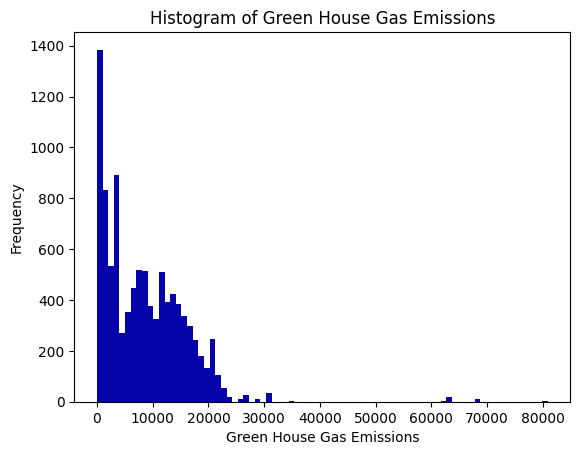

In [ ]:
# using 'matplotlib' package (plt.),  plot a histogram of 'join_cout'
plt.hist(x= metadata['emission'], bins='auto', color='#0504aa', rwidth=1) # rwidth=0.85 adds a bit of space between columns
plt.xlabel('Green House Gas Emissions')
plt.ylabel('Frequency')
plt.title('Histogram of Green House Gas Emissions')


We can also look at a histogram of deciles. They should be evenly distributed.

Text(0.5, 1.0, 'Histogram of Green House Gas Emission Deciles')

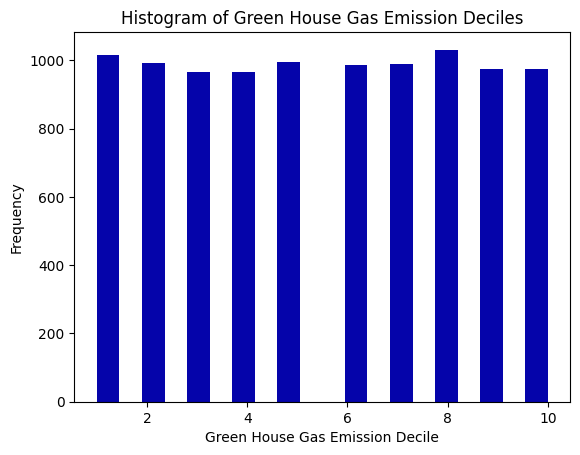

In [ ]:
# using 'matplotlib' package (plt.),  plot a histogram of 'join_cout'
plt.hist(x= metadata['decile'], bins='auto', color='#0504aa')
plt.xlabel('Green House Gas Emission Decile')
plt.ylabel('Frequency')
plt.title('Histogram of Green House Gas Emission Deciles')

We can also inspect the spatial distrubution of GHG deciles.

<Axes: xlabel='lon', ylabel='lat'>

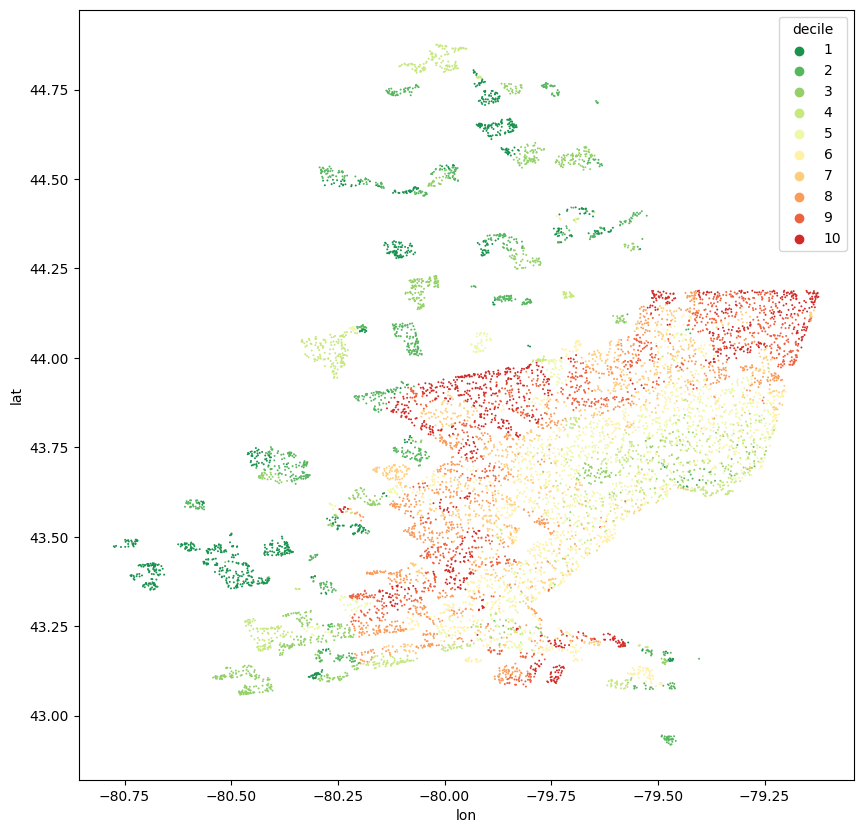

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

sns.scatterplot(x='lon', y='lat', data= metadata, hue='decile', palette = sns.color_palette("RdYlGn_r", 10), s = 2, linewidth = 0, ax = ax)

**Geohash Codes**  

A geohash code is a unique alpha-numeric code for gridsquares anywhere on earth. You can think of it as a way to spatially group our road segments together. This will be useful for when we split our data into train, validate, and test sets. The quick scatter plot below shows a section of the study area and the colors represent different geohash gridsquares. Notice how the colors are grouped together.         

More information on geohash codes can be found here:  
http://ellse.org/uncategorized/how-geohash-works/  

https://www.movable-type.co.uk/scripts/geohash.html  

<Axes: xlabel='lon', ylabel='lat'>

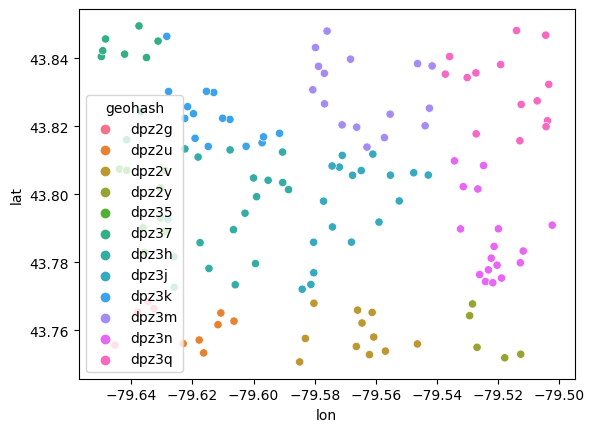

In [ ]:
# make a subset of the data that covers a small area. it would be cluttered and confusing if we plotted all the data
# data.loc[(condition) & (condition)] is used to filter by multiple conditions
sub_metadata = metadata.loc[(metadata['lat'] < 43.85) & (metadata['lat']> 43.75) & (metadata['lon'] < -79.5) & (metadata['lon'] > -79.65)]

# use seaborn to create a scatter plot
sns.scatterplot(x='lon', y='lat', data= sub_metadata, hue='geohash')
# note that this is just a scatter plot of longitude and latitute. it is distorted because it is not a true spatial plot. this is fine for exploratory purposes

# Preparing the Metadata


Now we'll setup the metadata:  
1. Create columns that point to the directory with the images;  
2. Create categorical columns for the quintiles that have "string" values instead of numeric values. We'll keep the numeric value quintile columns in case we want to use them later;  
3. Split the data into train, test, and validate set. We'll split randomly by geohash code. We split by geohash code in order to spatially separate the sets, which will help reduce the overlap of the images in the sets. This makes them more independent and reduces "cheating".


*Try later: After this workshop, you could try splitting the data completely randomly (i.e., by "id" instead of "geohash") to see if it changes the model performance in the test set. Does a little cheating results in higher performance?*

In [ ]:
###### create a column that includes the name of the directory where the images are ######
metadata['file'] = 'images_17/' + metadata['image_file_name'] # we will use the images at the zoom 17 level, but there is also a directory with images at a zoom 18 level (i.e. images_18) that we could chose to use

# we will train an image classification model that uses a categorical activation function. we need the deciles and quintiles to be strings
metadata[['quintile', 'decile']] = metadata[['quintile', 'decile']].astype(str) # should be str for cat
metadata[['emission']] = metadata[['emission']].astype(float)

# set seed and split metadata into train, val, and test
np.random.seed(1997)
train, validate, test = np.split(np.random.choice(pd.unique(metadata['geohash']), size = len(pd.unique(metadata['geohash'])), replace = False), [int(0.7*len(pd.unique(metadata['geohash']))), int(0.85*len(pd.unique(metadata['geohash'])))])
# np.random.choice puts the unique geohashs in a random order (replace = false means each unique geohash is sampled once) (there is no probability, so the default is each geohash has the same probability of being selected)
# np.split cuts the vector a specified locations, in this case the locations are 0.7 the length and 0.85 the length, this gives 0.7-0.15-0.15


metadata.loc[metadata['geohash'].isin(train), 'set'] = 'train'
# metadata['geohash'].isin(train) give a vector of T/F, it evaluates if the geohash row value in train
# metadata.loc[...] locates the rows based on the T/F vector
# ..., 'set'] = 'train' creates a new column 'set' and fills it with 'train', but only in the geohash that are in the train
metadata
# we can see that only the training set has been assigned

,image_file_name,lat,lon,geohash,emission,quintile,decile,random_numbers,file,set
0,11916.jpg,43.103690,-80.521350,dpwtp,3080.942833,2,3,2,images_17/11916.jpg,train
1,12095.jpg,43.110279,-80.517298,dpwtp,3080.942833,2,3,2,images_17/12095.jpg,train
2,11917.jpg,43.101965,-80.521775,dpwtp,3080.942833,2,3,1,images_17/11917.jpg,train
3,11547.jpg,43.104311,-80.526059,dpwtp,3080.942833,2,3,1,images_17/11547.jpg,train
4,10982.jpg,43.103519,-80.533546,dpwtp,3080.942833,2,3,1,images_17/10982.jpg,train
...,...,...,...,...,...,...,...,...,...,...
9886,40990.jpg,44.761237,-79.749121,dpzq9,1557.983497,1,2,2,images_17/40990.jpg,NaN
9887,44404.jpg,44.739476,-79.734812,dpzq9,1557.983497,1,2,1,images_17/44404.jpg,NaN
9888,44839.jpg,44.742610,-79.731439,dpzq9,1557.983497,1,2,1,images_17/44839.jpg,NaN
9889,43966.jpg,44.748484,-79.734897,dpzq9,1557.983497,1,2,2,images_17/43966.jpg,NaN


In [ ]:
# repeat for validate and test sets
metadata.loc[metadata['geohash'].isin(validate), 'set'] = 'validate'
metadata.loc[metadata['geohash'].isin(test), 'set'] = 'test'
metadata = metadata.sort_values(by='file')
metadata

,image_file_name,lat,lon,geohash,emission,quintile,decile,random_numbers,file,set
561,00004.jpg,43.473536,-80.775085,dpwx3,187.648987,1,1,2,images_17/00004.jpg,train
562,00011.jpg,43.471502,-80.773129,dpwx3,187.648987,1,1,2,images_17/00011.jpg,train
587,00015.jpg,43.474656,-80.769917,dpwx6,187.648987,1,1,2,images_17/00015.jpg,test
589,00031.jpg,43.471402,-80.758463,dpwx6,346.431148,1,1,1,images_17/00031.jpg,test
588,00039.jpg,43.491543,-80.748683,dpwx6,346.431148,1,1,1,images_17/00039.jpg,test
...,...,...,...,...,...,...,...,...,...,...
3444,99924.jpg,43.538474,-79.742789,dpxr9,6138.563805,3,5,1,images_17/99924.jpg,train
3440,99942.jpg,43.507430,-79.751018,dpxr9,13607.326540,4,8,1,images_17/99942.jpg,train
3347,99950.jpg,43.493634,-79.754671,dpxr3,8587.922871,3,6,1,images_17/99950.jpg,test
3338,99960.jpg,43.476390,-79.759235,dpxr3,8587.922871,3,6,1,images_17/99960.jpg,test


**Check the Data Split**  

We can count how many rows are in each set. We expect it to be roughly 70%, 15%, and 15% in the train, validate, and test sets. It probably won't be exact because we randomly split by geohash code and each geohash code can have different numbers of road segments within it.  

In [ ]:
# count number of rows in each set
metadata.set.value_counts()

train       7002
validate    1475
test        1414
Name: set, dtype: int64

# Managing Images



Let's take a look as some images. It's neat to see all four images associated with a site, but more importantly, this is a good way to confirm that the image paths are correct. I have spent way too many hours troubleshooting a model that won't train only to realize that it was bad filepaths to images. When troubleshooting code, check data types and check file paths - those are easy mistakes but easy fixes!  

Recall the organization of the folders:  
> ghg_images/
>> images_17/  
>> images_18/  

The code has been written to train the model using images only from the images_17 folder, but you could also try using images from the images_18 folder. You can see from the output from the code cell below that the images are centered on the same location, they just use different zoom levels.

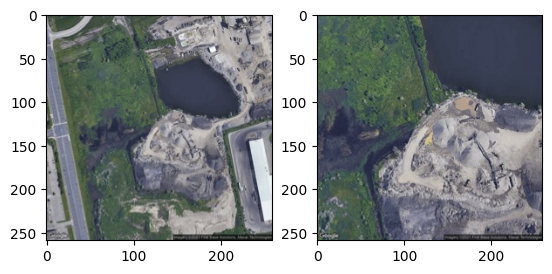

In [ ]:
# take a look at the images
# this is will also confirm that the image_dir actually leads to the images, this is a good check that helps with troubleshooting

# the parent directory for images, we will use this later on in the code. we will use this as a "global variable", which will be explained in a text cell further below
image_dir = "/content/gta_images/"

np.random.seed(seed = None) # unset the random seed so we get a random image
random_image_number = np.random.choice(metadata['file']).replace('images_17/', '').replace('images_18/', '')
np.random.seed(1997) # set the random seed back for reproducibility

img_17 = mpimg.imread(image_dir + 'images_17/' + random_image_number)
img_18 = mpimg.imread(image_dir + 'images_18/' + random_image_number)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(img_17)
axarr[1].imshow(img_18)

# you can run this code chunk several times in order to see different pictures

# Train Models

Now that the metadata is ready and we are happy with our images we can start setting up out models.

We start by defining our training and validation image data generators. These are functions that pre-process the data to prepare it for our CNN model. Here we are using *ImageDataGenerator().flow_from_dataframe()* which uses the metadata variable that we have set up. It expects the metadata to have a column indicating image filenames and a column indicating image labels (i.e., GHG emissions). *ImageDataGenerator()* will resize images to a target size. Different model architectures have different acceptable model sizes. Xception's default is 299 x 299, but it is pretty flexible and can take anything larger than 150 x 150. EfficientNetB2 on the other hand has an architecture that requires images to be 260 x 260. You can read more about these different architectures in the Keras documentation. This exercise will use the Xception model architecture.      


Instead of using a dataframe input, we could have used *flow_from_directory()* which uses directories (i.e., folders) for each category of image. That way, the directory acts as a label for all the images within it. For us, that would require a folder for each quintile. Here is a tutorial on using *flow_from_directory()*:    
https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

# Global Variables - One Change in One Place

We have the option to train the models to predict either GHG quintiles or deciles. You could modify the code each time you switch from one to the other, or you can use *input()* with *if else* statements to help you manage that change. Here we do that to create our set of global variables. Think of this as "One Change in One Place". This is a very simple example to demonstrate how it works, but the other example in this lab (i.e. ultrafine particles in Colombia) has a much more complex implementation which demonstrates the advantage of this approach.

In [ ]:
target = input("What form of GHG: quintile, or decile? ")

if target == 'quintile':
    output_units = 5
else:
  if target == 'decile':
      output_units = 10
  else:
    print('!!!TYPO in form of GHG')

What form of GHG: quintile, or decile? quintile


In [ ]:
# define the training and validation generators

generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=K.applications.xception.preprocess_input,
                                                     horizontal_flip=True,
                                                     vertical_flip = True)


train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='train', [target, 'file']].reset_index(drop=True),  # you can see this line uses the 'target' that we defined in the code cell above in order to point to the appropriate column we want to train on (i.e. quintile or decile)
                                                directory= image_dir, # we already defined our image directory when we were ploting the pictures
                                                x_col= 'file', # this is the filename of the images. recall that we included the "images_17/" directory name to the image file name
                                                y_col=target,  # as mentioned, this is 'target' we defined in the code cell above in order to point to the appropriate column we want to train on (i.e. quintile or decile)
                                                class_mode= 'categorical', # categorical
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', # this is the type of image. Note that some models don't work with grayscale
                                                batch_size=64,
                                                shuffle=True)

validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='validate', [target, 'file']].reset_index(drop=True),
                                                     directory= image_dir,
                                                     x_col= 'file',
                                                     y_col=target,
                                                     class_mode='categorical',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)


Found 7002 validated image filenames belonging to 5 classes.
Found 1475 validated image filenames belonging to 5 classes.


You will see output telling you how many validated image filenames were found. If any images were missing, it will tell you here.   

# Define Callbacks

"Callbacks" are actions that we want Keras to do during training and we can set conditions for those actions based on model performance in the validation or training sets. In our case we want to define criteria for early stopping and reducing learning rates. We also want to save a log of model performance and save only the best model. We could save the model from each epoch, but that can take up a lot of space and we probably aren't interested in anything other than the best model. If you're tight on space, you can always just save the models wieghts instead of the entire model.

Here we have set the "patience" of our callbacks to be very low in the interest of time. For example, the early_stopping callback is set to stop the training if the model doesn't improve over 4 epochs of training. Typically you would set that callback to something much higher (e.g. 20), but in this lab exercise we are just trying to show how the code works. The other lab exercise (Bucaramanga Colombia Ultrafine Particles) is more complex and has higher values for callback "patience".

In [ ]:
# define callbacks

# stop the training if the metric of interest (accuracy in validation data) doesn't improve during a certain number of epochs (set to 4 here, but typically this will be something like 20 or more). there's no sense in continuous training if the model isn't leraning
early_stopping = K.callbacks.EarlyStopping(monitor= 'val_accuracy', patience=4)


# reduce learning by a certain factor if the metric of interest (accuracy) doesn't improve during a certain number of epochs (set to 2 here, but typically this will be something like 10 or more)
reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor= 'val_accuracy', factor=0.1, patience=2, mode= 'max', verbose=1)


# save a log of model performance. notice how the file name will change depending on which model we are training (e.g., quintile_ghg_model_log.csv)
csv_logger = K.callbacks.CSVLogger('/content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model_log/' + target + '_ghg_model_log.csv')

# save the best model
model_checkpoint = K.callbacks.ModelCheckpoint('/content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model/' + target + '_ghg_model.hdf5', monitor= 'val_accuracy', mode= 'max', save_weights_only=False, save_best_only=True)


# Compile and Train Model

Next we define the model compile function. Compiling sets the shape of input tensors, the model architecture, any initial weights, the activation function, and several other model parameters you can see in the code below.

**Initial Weights**

We'll use inital weights from a model that has already been trained. This is called "transfer learning". We can use weights from models trained on the "ImageNet" database. It has millions of labeled images and is used in research. The images have nothing to do with green house gas emissions, but it costs us nothing to use these initial weights so we may as well.



In [ ]:
###############################################################################
######## TRAIN MODEL FROM SCRATCH (using imagenet weights) ####################
###############################################################################

# define our model compiling functions.
def get_compiled_model():
    # define model
    model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
    conv_base = K.applications.Xception(include_top=False, weights= "imagenet", input_tensor=model_input)
    model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
    model_output = K.layers.Dense(units= output_units, activation='softmax')(model_output)  # this is what makes it a categorial model, notice that the units is either 5 or 10
    model = K.models.Model(inputs=model_input, outputs=model_output)
    model.compile(
        optimizer=K.optimizers.Nadam(learning_rate = 0.01),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    return model


You have defined the get_compiled_model() function, now we want to actually compile it. We could have just run each line separetely, but we find it nice to have them all in once spot.

> ***Compiling the model will take 2-10 seconds. You should see a progess bar.***

In [ ]:
model = get_compiled_model()

83683744/83683744 [==============================] - 1s 0us/step


Now you are ready to train (i.e., fit) your model! If you set epochs to 5, this should take 10-15 mins. You will see progress bars for each epoch.

> ***Training will take a while (~15 mins for 5 epochs) , so plan accordingly (i.e. go grab a coffee if you want!).***

In [ ]:
model.fit(train_generator,
          validation_data=validate_generator,
          epochs=20, # setting to only 5 epochs in the interest of time, which takes about 15 minutes
          steps_per_epoch=int(np.ceil(train_generator.samples/train_generator.batch_size)),
          validation_steps=int(np.ceil(validate_generator.samples/validate_generator.batch_size)),
          callbacks=[early_stopping, reduce_lr_on_plateau, csv_logger, model_checkpoint])

Epoch 1/20
110/110 [==============================] - 189s 1s/step - loss: 1.2626 - accuracy: 0.4533 - val_loss: 12.4848 - val_accuracy: 0.2841 - lr: 0.0100
Epoch 2/20
110/110 [==============================] - 146s 1s/step - loss: 1.2475 - accuracy: 0.4673 - val_loss: 3.0323 - val_accuracy: 0.3505 - lr: 0.0100
Epoch 3/20
110/110 [==============================] - 146s 1s/step - loss: 1.2137 - accuracy: 0.4821 - val_loss: 3.2963 - val_accuracy: 0.3410 - lr: 0.0100
Epoch 4/20
110/110 [==============================] - ETA: 0s - loss: 1.2059 - accuracy: 0.4886
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
110/110 [==============================] - 146s 1s/step - loss: 1.2059 - accuracy: 0.4886 - val_loss: 8.2969 - val_accuracy: 0.3234 - lr: 0.0100
Epoch 5/20
110/110 [==============================] - 147s 1s/step - loss: 1.1435 - accuracy: 0.5164 - val_loss: 1.4028 - val_accuracy: 0.4129 - lr: 1.0000e-03
Epoch 6/20
110/110 [==============================] - 

In [ ]:

generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function= K.applications.xception.preprocess_input,
                                                      horizontal_flip=False,
                                                      vertical_flip = False) # set to false if using street images

# you could just generate predictions for the test set, but here we will generate predictions for the entire data set
# keep this in mind for when we later evaluate the results. at that point we will have to make sure we are only evaluating in the test set.
test_generator = generator.flow_from_dataframe(dataframe=metadata[[target, 'file']].reset_index(drop=True),
                                               directory= image_dir,
                                               x_col= 'file',
                                               class_mode= 'input',
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               batch_size= 64,
                                               shuffle=False)

Found 9891 validated image filenames.


In [ ]:
# load the model you just trained, this will take about 30s
model = K.models.load_model('/content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model/' + target + '_ghg_model.hdf5')

# create a copy of the metadata that we will add the predictions to. this will be our results file
results = metadata

# generate predictions and save the file as a csv
results['prediction'] = model.predict(x=test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))).argmax(axis = -1)
results.to_csv(path_or_buf='/content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model_predictions/'+ target +'_ghg_predictions.csv', index=False)

155/155 [==============================] - 58s 368ms/step


In [ ]:
results

,image_file_name,lat,lon,geohash,emission,quintile,decile,random_numbers,file,set,prediction
561,00004.jpg,43.473536,-80.775085,dpwx3,187.648987,1,1,2,images_17/00004.jpg,train,1
562,00011.jpg,43.471502,-80.773129,dpwx3,187.648987,1,1,2,images_17/00011.jpg,train,1
587,00015.jpg,43.474656,-80.769917,dpwx6,187.648987,1,1,2,images_17/00015.jpg,test,0
589,00031.jpg,43.471402,-80.758463,dpwx6,346.431148,1,1,1,images_17/00031.jpg,test,0
588,00039.jpg,43.491543,-80.748683,dpwx6,346.431148,1,1,1,images_17/00039.jpg,test,1
...,...,...,...,...,...,...,...,...,...,...,...
3444,99924.jpg,43.538474,-79.742789,dpxr9,6138.563805,3,5,1,images_17/99924.jpg,train,2
3440,99942.jpg,43.507430,-79.751018,dpxr9,13607.326540,4,8,1,images_17/99942.jpg,train,2
3347,99950.jpg,43.493634,-79.754671,dpxr3,8587.922871,3,6,1,images_17/99950.jpg,test,3
3338,99960.jpg,43.476390,-79.759235,dpxr3,8587.922871,3,6,1,images_17/99960.jpg,test,2


Congrats! You have trained a deep CNN and used it to generate GHG predictions using images. What now?

Now you should evaluate your model.


## Model Evaluation

**Model Log**

Before we dig into predictions, we can take a look at the model log to see the change in performance in the training and validation sets during training. Perfromance in the training set is usally higher that in the validation set, though we hope that they end up being pretty close. If they are not close, then that is an indication that the model is overfit. You would also like to see the lines in the plot flattening out in later epochs. If the lines are still very wiggly, then the models could probably benefit from more training epochs.  

If you are training on categorical quintiles, the y axis will be accuracy. Randomly guessing quintiles would results in an accuracy of 0.2,

(0.0, 1.0)

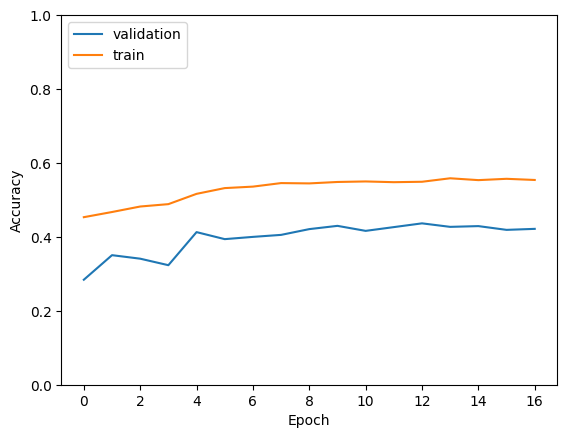

In [ ]:
# read in the model log
train_log = pd.read_csv('/content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model_log/' + target + '_ghg_model_log.csv')

# if we are training on categorical, then we want to look at accuracy.
plt.plot(train_log['epoch'], train_log['val_accuracy']) # val_rmse
plt.plot(train_log['epoch'], train_log['accuracy'])
plt.legend(["validation", "train"], loc="upper left")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(ymin = 0, ymax = 1)


**Comparing Observed to Predicted**

Read in the results dataframe from the csv you saved and see how the observed value compare to the predicted values.

In [ ]:
# read in the predictions
results = pd.read_csv('/content/drive/MyDrive/colab_files/sharp_d2_GHG/output/model_predictions/'+ target +'_ghg_predictions.csv')

# create categorical columns for use in the confusion matrix
if target == 'quintile':
    results[['observed_cat', 'prediction_cat']] = results[['quintile', 'prediction']].astype(str)
else:
  if target == 'decile':
      results[['observed_cat', 'prediction_cat']] = results[['decile', 'prediction']].astype(str)


# create a dataframe that is just the test set.
results_test = results.loc[results['set'] == 'test', ]
results_val = results.loc[results['set'] == 'validate', ]
results_train = results.loc[results['set'] == 'train', ]

We can create a "confusion matrix" that compares the predicted GHG categories to the observed GHG categories. This gives us an idea of how well the model is performing. We can also calculate the accuracy. Note that randomly guessing deciles would give an accuracy of 0.1 and randomly guessing quintiles would give an accuracy of 0.2. With that in mind, how did the model perform? In the interest of time, we did not train the model for very long, so we would not expect the model to perform much better than random guessing.

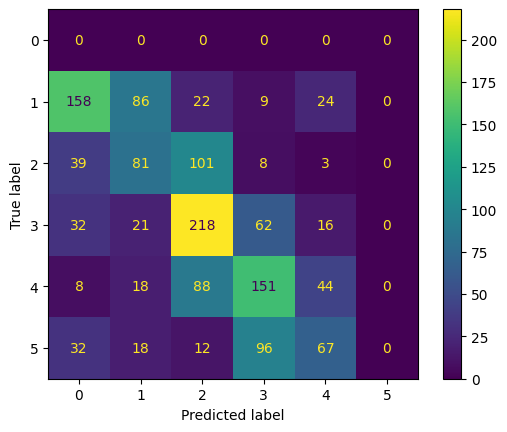

Accuracy   : 0.2072135785007072


In [ ]:
confusion_matrix = metrics.confusion_matrix(results_test[['observed_cat']], results_test[['prediction_cat']])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

accuracy = metrics.accuracy_score(results_test[['observed_cat']], results_test[['prediction_cat']])
print("Accuracy   :", accuracy)

We trained the model on deciles or quintiles, but we also have continuous values for the observed GHG emissions. We can compare continuous observed values to the predicted deciles/quintiles in a scatter plot. On the left is all the data and on the right is just in the test set. Model evaluation should only be done with the independent test set, but it can be interesting to look at all the data as well.  

Text(0, 0.5, 'Observed GHG Emisson')

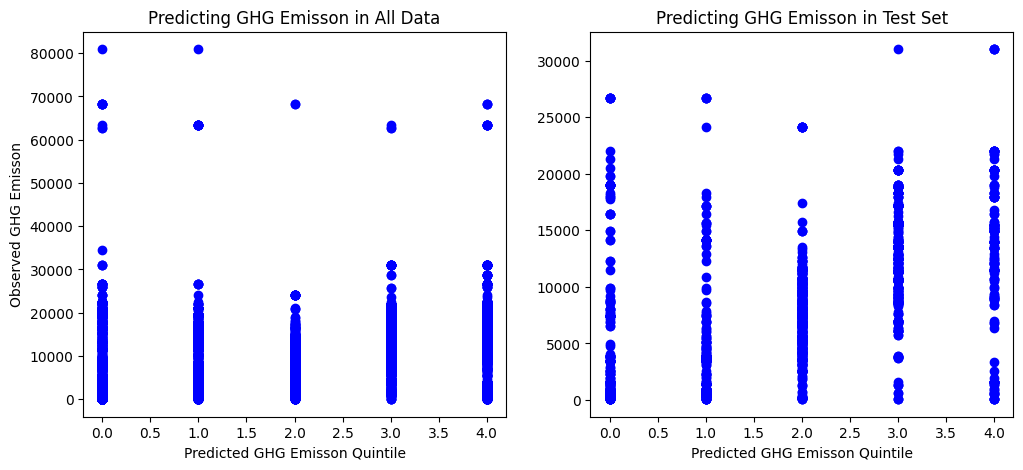

In [ ]:

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(results['prediction'], results['emission'], 'bo')
ax2.plot(results_test['prediction'], results_test['emission'], 'bo')

if target == 'quintile':
  ax.set_xlabel('Predicted GHG Emisson Quintile')
  ax2.set_xlabel('Predicted GHG Emisson Quintile')

if target == 'decile':
  ax.set_xlabel('Predicted GHG Emisson Decile')
  ax2.set_xlabel('Predicted GHG Emisson Decile')

ax.set_title('Predicting GHG Emisson in All Data')
ax2.set_title('Predicting GHG Emisson in Test Set')
ax.set_ylabel('Observed GHG Emisson')

 Lastly, we can also see how much of the variance in the continuous observed values is explained by our predicted quintiles/deciles. To do so, we fit a linear model and calculate the R2 value.

In [ ]:
x_test, y_test = results_test[['prediction']], results_test[['emission']]

results_linear_model_test = LinearRegression().fit(x_test, y_test)
r_sq = results_linear_model_test.score(x_test, y_test)

y_test_pred = results_linear_model_test.predict(x_test)
mse = metrics.mean_squared_error(y_test, y_test_pred)

print(f"MSE in test set is: {mse}")
print(f"R2 in test set is: {r_sq}")
print(f"Test set regression slopes is: {results_linear_model_test.coef_}")
print(f"Test set intercept is: {results_linear_model_test.intercept_}")

MSE in test set is: 32306450.389350407
R2 in test set is: 0.15350490682983653
Test set regression slopes is: [[1401.44662459]]
Test set intercept is: [5645.68530536]


You can record the accuracy, MSE, R2, and your model details here: https://docs.google.com/spreadsheets/d/1L2GVVkAXDGLgbGxGWsNMNGkR_bGIySMPh8LugFVxt5o/edit?usp=sharing


You likely have a pretty poor performing model, which is to be expected for this exercise since we did not have enough time today to train the model using all the data and and we didn't train for very long (i.e. number of epochs). Nonetheless, you still trained a CNN model!

Now you can try the other lab exercise. It is a more complex example and it trains CNN models to predict within-variations in outdoor ultrafine particles in Bucaramanga Colombia.


# END